# Results

## Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sys
import os
import random
import math
import pickle

from matplotlib import pyplot as plt

from PIL import Image

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras.models import model_from_json

from dotenv import load_dotenv

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sys.path.append("../Library/")
import deep_learning as dl
import image_manipulation as ima
import machine_learning as ml
import display as dp

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PATH_GDRIVE = os.getenv('GDRIVE_FOLDER')
PATH_IMAGES = os.path.join(PATH_GDRIVE, "MFP - Satellogic/images/")
PATH_DATA = os.path.join(PATH_GDRIVE.replace("MDS/",""), 'Colab/MasterThesis/Data')
PATH_HISTORY = os.path.join(PATH_GDRIVE.replace("MDS/",""), 'Colab/MasterThesis/History')
PATH_MODELS = os.path.join(PATH_GDRIVE.replace("MDS/",""), 'Colab/MasterThesis/Models')
PATH_RESULTS = os.path.join(PATH_GDRIVE.replace("MDS/",""), 'Colab/MasterThesis/Results')

CATEGORIES = ["agriculture", "forest-woodland", "semi-desert", "shrubland-grassland"]
CATEGORY_COLOR = {
    "agriculture": "lime",
    "forest-woodland": "green",
    "semi-desert": "sandybrown",
    "shrubland-grassland": "saddlebrown",
    "all-0.3m_100n": "cyan",
    "all-0.3m_200n": "blue",
    "all-0.3m": "blue",
    "all-1m_100n": "magenta",
    "all-1m_200n": "indigo",
    "all-1m": "indigo",
}

labels = [0, 1, 2]

fig_filename_formatter = "../report/Figures/results/{}.png"
tab_filename_formatter = "../report/Tables/{}.tex"

In [5]:
def load_results(folder):
    count = 0
    for file in os.listdir(folder):
        if file.startswith('result') and count == 0:
            df_results = pd.read_csv(os.path.join(folder, file), )
            count += 1
        elif file.startswith('result') and count > 0:
            df_results = df_results.append(pd.read_csv(os.path.join(folder, file)))
            count += 1
    return df_results


def load_grouped_results(path, acc_threshold):
    df_results = load_results(path)
    df_results = df_results[df_results["accuracy"] > acc_threshold]
    grouped_results = df_results.groupby(['resolution'], as_index=False).agg({
        'accuracy':['mean','std'], 
        'accuracy_agriculture':['mean','std'],
        'accuracy_forest-woodland':['mean','std'],
        'accuracy_semi-desert':['mean','std'],
        'accuracy_shrubland-grassland':['mean','std'],
    })
    return grouped_results


def load_res_and_sizes(base_res, base_size, n_res):
    sizes = {base_res: (base_size, base_size)}
    for factor in range(2, n_res):
        res = round(base_res * factor,1)
        size = round(base_size/factor)
        sizes[res] = (size, size)
    print("Sizes dictionary:\n", sizes)
    return sizes


def save_obj(obj, fullpath):
    with open(fullpath + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(fullpath):
    with open(fullpath, 'rb') as f:
        return pickle.load(f)

---

## Convergence plots

Convergence history for each dataset and all resolutions

### 0.3m dataset

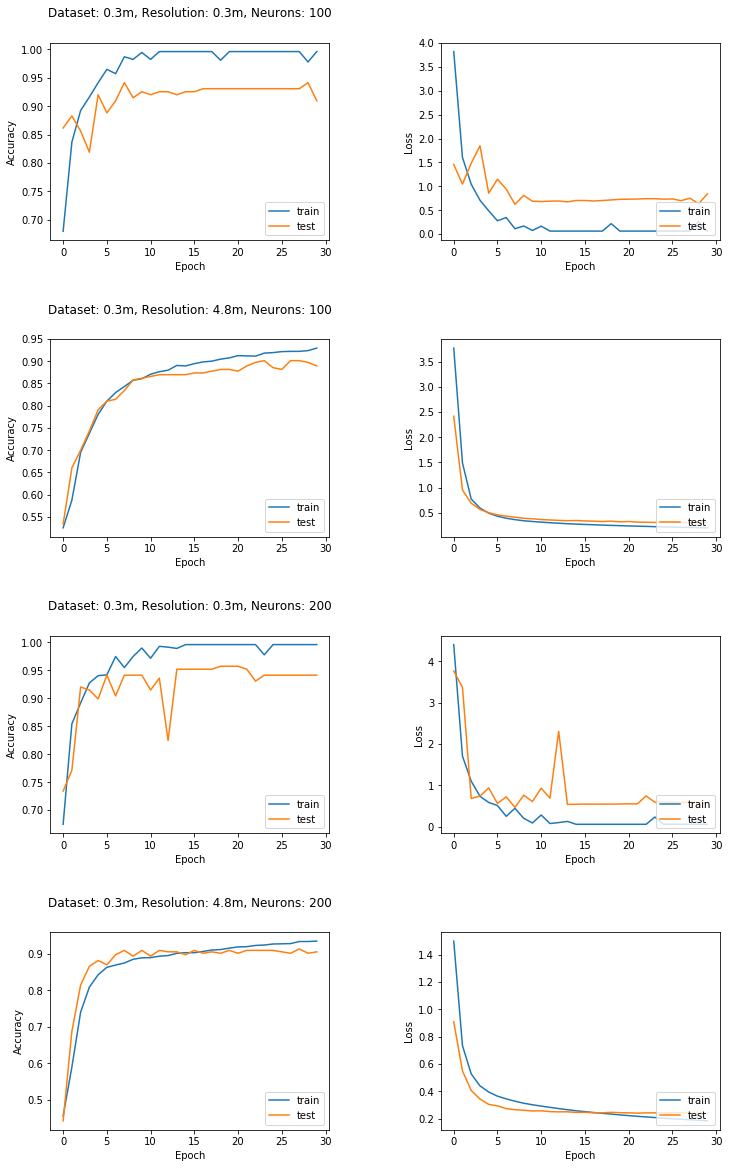

In [6]:
history_samples = [
    {"experiment": "0.3m_100n", "res": 0.3, "fold": 2},
    {"experiment": "0.3m_100n", "res": 4.8, "fold": 2},
    {"experiment": "0.3m_200n", "res": 0.3, "fold": 3},
    {"experiment": "0.3m_200n", "res": 4.8, "fold": 5},
]
title_formatter = "Dataset: {}, Resolution: {}m, Neurons: {}"

width_per_plot = 6
height_per_plot = 5
array_width = 2
array_height = math.ceil(len(history_samples)*2/array_width)

fig = plt.figure(figsize=(width_per_plot*array_width, height_per_plot*array_height))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for idx, sample in enumerate(history_samples):
    dataset, neurons = sample["experiment"].split("_")
    
    #load file
    path = os.path.join(PATH_HISTORY, sample["experiment"])
    file_path = os.path.join(path, "history_res{}_fold{}.pkl".format(sample["res"], sample["fold"]))
    history = load_obj(file_path)
    
    #plot
    ax = fig.add_subplot(array_height,array_width, 2*idx+1) 
    plt.plot(history['acc'], label="train")
    plt.plot(history['val_acc'], label="test")
    ax.set(
        xlabel="Epoch",
        ylabel="Accuracy",
    )
    ax.legend(loc='lower right')
    plt.title(title_formatter.format(dataset, sample["res"], neurons[:-1]), y=1.1)
    
    ax = fig.add_subplot(array_height,array_width, 2*idx+2) 
    plt.plot(history['loss'], label="train")
    plt.plot(history['val_loss'], label="test")
    ax.set(
        xlabel="Epoch",
        ylabel="Loss",
    )
    ax.legend(loc='lower right')
    
plt.show()
fig.savefig(fig_filename_formatter.format("convergence_plots_03m"), bbox_inches='tight')

### 1m dataset

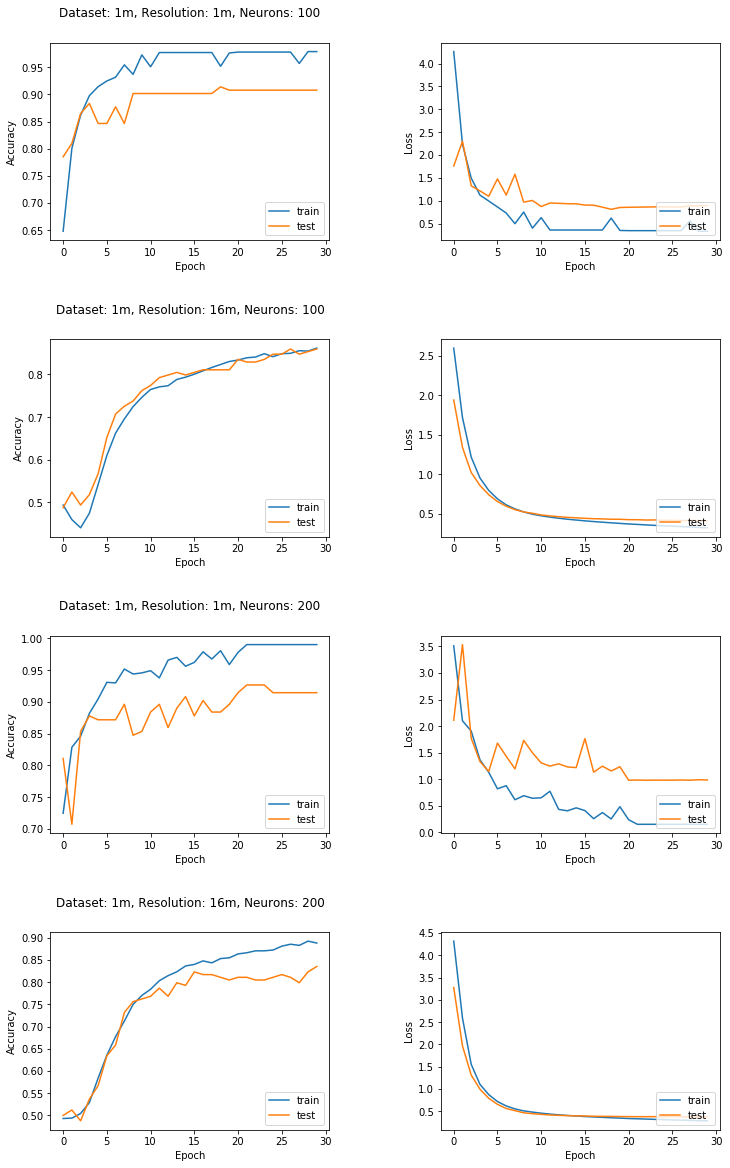

In [10]:
history_samples = [
    {"experiment": "1m_100n", "res": 1, "fold": 6},
    {"experiment": "1m_100n", "res": 16, "fold": 0},
    {"experiment": "1m_200n", "res": 1, "fold": 1},
    {"experiment": "1m_200n", "res": 16, "fold": 4},
]
title_formatter = "Dataset: {}, Resolution: {}m, Neurons: {}"

width_per_plot = 6
height_per_plot = 5
array_width = 2
array_height = math.ceil(len(history_samples)*2/array_width)

fig = plt.figure(figsize=(width_per_plot*array_width, height_per_plot*array_height))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for idx, sample in enumerate(history_samples):
    dataset, neurons = sample["experiment"].split("_")
    
    #load file
    path = os.path.join(PATH_HISTORY, sample["experiment"])
    file_path = os.path.join(path, "history_res{}_fold{}.pkl".format(sample["res"], sample["fold"]))
    history = load_obj(file_path)
    
    #plot
    ax = fig.add_subplot(array_height,array_width, 2*idx+1) 
    plt.plot(history['acc'], label="train")
    plt.plot(history['val_acc'], label="test")
    ax.set(
        xlabel="Epoch",
        ylabel="Accuracy",
    )
    ax.legend(loc='lower right')
    plt.title(title_formatter.format(dataset, sample["res"], neurons[:-1]), y=1.1)
    
    ax = fig.add_subplot(array_height,array_width, 2*idx+2) 
    plt.plot(history['loss'], label="train")
    plt.plot(history['val_loss'], label="test")
    ax.set(
        xlabel="Epoch",
        ylabel="Loss",
    )
    ax.legend(loc='lower right')
    
plt.show()
fig.savefig(fig_filename_formatter.format("convergence_plots_1m"), bbox_inches='tight')

---

## Accuracy vs Resolution - Tables

In [7]:
def export_results_to_latex(df, fname):
    DECIMALS = 4
    
    latex_table = df.to_latex(
        index=False,
        multirow=True,
        multicolumn_format="c",
        float_format="%.{}f".format(DECIMALS),
    )
    
    latex_table = latex_table.replace("resolution","resolution (m)")
    latex_table = latex_table.replace("accuracy\_","")
    latex_table = latex_table.replace("accuracy","All categories")
    latex_table = latex_table.replace("mean","mean acc.")
    #latex_table = latex_table.replace("-","-\n")
    
    with open(fname, "w") as f:
        f.write(latex_table)
        
    return latex_table

### 0.3m dataset

In [8]:
ACC_THRESHOLD = 0.6
RES_NAME = "0.3m_100n"

path_results_res = os.path.join(PATH_RESULTS, RES_NAME)
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
export_results_to_latex(grouped_results, tab_filename_formatter.format("Results_03m_100n"))
grouped_results

resolution  accuracy           accuracy_agriculture            \
                   mean       std                 mean       std   
0         0.3  0.922650  0.021109             0.984988  0.024838   
1         0.6  0.938265  0.019016             0.969895  0.021593   
2         0.9  0.934746  0.009557             0.943872  0.024420   
3         1.2  0.927126  0.012002             0.948765  0.037394   
4         1.5  0.928771  0.013940             0.962184  0.028457   
5         1.8  0.922409  0.015422             0.967825  0.031056   
6         2.1  0.910773  0.024092             0.961836  0.016807   
7         2.4  0.912029  0.020598             0.957317  0.027975   
8         2.7  0.895206  0.022289             0.961970  0.021555   
9         3.0  0.889296  0.018882             0.957148  0.006661   
10        3.3  0.895711  0.020866             0.953899  0.031140   
11        3.6  0.878415  0.018419             0.941467  0.039353   
12        3.9  0.881912  0.015263             0.945648  0.018602   
13        4.2  0.880370  0.007048             0.938883  0.030532   
14        4.5  0.871494  0.017946             0.938299  0.038992   
15        4.8  0.869008  0.016007             0.950759  0.015717   

   accuracy_forest-woodland           accuracy_semi-desert            \
                       mean       std                 mean       std   
0                  0.862952  0.062422             0.888195  0.045290   
1                  0.877914  0.026879             0.923058  0.041007   
2                  0.894400  0.056081             0.932717  0.021628   
3                  0.906050  0.037328             0.914980  0.032830   
4                  0.867915  0.038284             0.914447  0.030946   
5                  0.886371  0.065021             0.901365  0.036287   
6                  0.874926  0.045413             0.888503  0.057141   
7                  0.868646  0.059010             0.886732  0.035779   
8                  0.863125  0.019130             0.851036  0.034991   
9                  0.871697  0.019733             0.833952  0.047234   
10                 0.872257  0.047933             0.852916  0.034093   
11                 0.872656  0.044166             0.819935  0.034795   
12                 0.873805  0.033042             0.839721  0.036401   
13                 0.852513  0.026730             0.844391  0.053305   
14                 0.844512  0.030770             0.830137  0.034045   
15                 0.856920  0.051714             0.779826  0.045557   

   accuracy_shrubland-grassland            
                           mean       std  
0                      0.956136  0.022837  
1                      0.974806  0.019762  
2                      0.957836  0.021177  
3                      0.939917  0.023142  
4                      0.960408  0.021484  
5                      0.937062  0.022055  
6                      0.921566  0.037127  
7                      0.935212  0.026292  
8                      0.911657  0.049580  
9                      0.905505  0.045453  
10                     0.912149  0.042453  
11                     0.893477  0.029884  
12                     0.879647  0.017764  
13                     0.896066  0.022232  
14                     0.882137  0.020640  
15                     0.903548  0.031026

In [9]:
ACC_THRESHOLD = 0.6
RES_NAME = "0.3m_200n"

path_results_res = os.path.join(PATH_RESULTS, RES_NAME)
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
export_results_to_latex(grouped_results, tab_filename_formatter.format("Results_03m_200n"))
grouped_results

resolution  accuracy           accuracy_agriculture            \
                   mean       std                 mean       std   
0         0.3  0.933511  0.011284             0.954044  0.023397   
1         0.6  0.956480  0.010386             0.966330  0.029593   
2         0.9  0.940641  0.013919             0.951524  0.027267   
3         1.2  0.939026  0.012210             0.955892  0.031690   
4         1.5  0.924901  0.010607             0.969600  0.011615   
5         1.8  0.919823  0.008705             0.962711  0.024309   
6         2.1  0.906463  0.026268             0.963800  0.023805   
7         2.4  0.920913  0.015227             0.968892  0.012863   
8         2.7  0.902150  0.015013             0.964353  0.024801   
9         3.0  0.895719  0.018061             0.956751  0.026943   
10        3.3  0.908571  0.015569             0.967879  0.039696   
11        3.6  0.887802  0.012542             0.966927  0.024969   
12        3.9  0.880377  0.007799             0.949518  0.019132   
13        4.2  0.877417  0.007768             0.940486  0.042171   
14        4.5  0.874454  0.014958             0.942824  0.039660   
15        4.8  0.877403  0.026498             0.950543  0.022839   

   accuracy_forest-woodland           accuracy_semi-desert            \
                       mean       std                 mean       std   
0                  0.872475  0.094638             0.928571  0.025254   
1                  0.928146  0.030388             0.956887  0.012033   
2                  0.905891  0.026393             0.942956  0.031356   
3                  0.897619  0.048250             0.935131  0.033578   
4                  0.879293  0.044343             0.894180  0.024959   
5                  0.894675  0.043852             0.897468  0.040411   
6                  0.877950  0.059661             0.871102  0.054079   
7                  0.867737  0.024663             0.900920  0.035423   
8                  0.858710  0.032665             0.883714  0.042603   
9                  0.871727  0.043993             0.849853  0.059727   
10                 0.870673  0.034548             0.884424  0.042605   
11                 0.893977  0.040192             0.816050  0.033894   
12                 0.863519  0.034457             0.836770  0.036537   
13                 0.851618  0.033002             0.838725  0.037361   
14                 0.847275  0.049262             0.828024  0.032812   
15                 0.853318  0.040400             0.817560  0.049673   

   accuracy_shrubland-grassland            
                           mean       std  
0                      0.961298  0.010539  
1                      0.967138  0.018948  
2                      0.954968  0.027331  
3                      0.962211  0.015253  
4                      0.953588  0.027956  
5                      0.931194  0.030362  
6                      0.918984  0.041531  
7                      0.943542  0.021120  
8                      0.911135  0.024659  
9                      0.911245  0.042372  
10                     0.918284  0.022996  
11                     0.894001  0.044245  
12                     0.885334  0.026427  
13                     0.892345  0.034257  
14                     0.888603  0.030854  
15                     0.899977  0.039596

### 1m dataset

In [10]:
ACC_THRESHOLD = 0.6
RES_NAME = "1m_100n"

path_results_res = os.path.join(PATH_RESULTS, RES_NAME)
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
export_results_to_latex(grouped_results, tab_filename_formatter.format("Results_1m_100n"))
grouped_results

resolution  accuracy           accuracy_agriculture            \
                   mean       std                 mean       std   
0           1  0.863634  0.042535             1.000000  0.000000   
1           2  0.900094  0.013844             0.980324  0.030561   
2           3  0.904097  0.024647             0.984568  0.024614   
3           4  0.897026  0.022725             0.984568  0.024614   
4           5  0.886545  0.039145             0.980867  0.032777   
5           6  0.879984  0.028180             0.967303  0.035159   
6           7  0.858652  0.034998             0.958375  0.048194   
7           8  0.869876  0.022956             0.983135  0.028872   
8           9  0.833799  0.014761             0.934083  0.056158   
9          10  0.823436  0.026298             0.991071  0.025254   
10         11  0.821907  0.024852             0.970328  0.064477   
11         12  0.811222  0.025720             0.948995  0.033262   
12         13  0.814682  0.036924             0.966648  0.048840   
13         14  0.783675  0.016724             0.935069  0.069046   
14         15  0.780844  0.024457             0.945724  0.028914   
15         16  0.798952  0.036077             0.940315  0.063495   

   accuracy_forest-woodland           accuracy_semi-desert            \
                       mean       std                 mean       std   
0                  0.838733  0.048854             0.856056  0.043222   
1                  0.899132  0.063413             0.884314  0.041326   
2                  0.924450  0.027999             0.874160  0.053739   
3                  0.874281  0.028024             0.878636  0.048131   
4                  0.869207  0.057679             0.882052  0.032818   
5                  0.868454  0.046659             0.841909  0.046863   
6                  0.835973  0.065331             0.846813  0.058331   
7                  0.878822  0.044231             0.843203  0.030340   
8                  0.833014  0.056481             0.808583  0.043082   
9                  0.815869  0.055256             0.781525  0.042020   
10                 0.805180  0.050682             0.790128  0.053773   
11                 0.817777  0.036247             0.760605  0.036320   
12                 0.798840  0.092100             0.771934  0.072322   
13                 0.768235  0.040317             0.739832  0.054289   
14                 0.766316  0.067270             0.725676  0.047195   
15                 0.767976  0.070030             0.771285  0.085726   

   accuracy_shrubland-grassland            
                           mean       std  
0                      0.854131  0.064649  
1                      0.888068  0.042962  
2                      0.880510  0.031484  
3                      0.912918  0.022224  
4                      0.879672  0.047187  
5                      0.909325  0.050796  
6                      0.868185  0.059842  
7                      0.849780  0.033460  
8                      0.824495  0.054280  
9                      0.819885  0.069980  
10                     0.819260  0.070230  
11                     0.811787  0.081432  
12                     0.824403  0.057183  
13                     0.799910  0.039714  
14                     0.801714  0.043941  
15                     0.814055  0.076358

In [11]:
ACC_THRESHOLD = 0.6
RES_NAME = "1m_200n"

path_results_res = os.path.join(PATH_RESULTS, RES_NAME)
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
export_results_to_latex(grouped_results, tab_filename_formatter.format("Results_1m_200n"))
grouped_results

resolution  accuracy           accuracy_agriculture            \
                   mean       std                 mean       std   
0           1  0.886344  0.030519             0.969318  0.043197   
1           2  0.896207  0.015615             0.987500  0.027951   
2           3  0.879134  0.026651             0.963492  0.051922   
3           4  0.899100  0.033893             0.971685  0.031741   
4           5  0.891269  0.030085             0.976389  0.032424   
5           6  0.865474  0.019359             0.972801  0.044984   
6           7  0.869450  0.032062             0.948743  0.058838   
7           8  0.880303  0.023009             0.956349  0.059159   
8           9  0.808660  0.037802             0.937036  0.070640   
9          10  0.821053  0.035238             0.930092  0.063388   
10         11  0.824179  0.013030             0.945775  0.060398   
11         12  0.803581  0.025238             0.957676  0.047317   
12         13  0.821911  0.040820             0.954824  0.038431   
13         14  0.806416  0.034306             0.957512  0.037398   
14         15  0.798199  0.036773             0.963752  0.039736   
15         16  0.798938  0.024662             0.952757  0.046627   

   accuracy_forest-woodland           accuracy_semi-desert            \
                       mean       std                 mean       std   
0                  0.866124  0.045171             0.897403  0.035168   
1                  0.895057  0.052574             0.881923  0.040098   
2                  0.871307  0.076142             0.887342  0.033074   
3                  0.899870  0.045292             0.873388  0.055492   
4                  0.882299  0.057741             0.859063  0.024270   
5                  0.860881  0.047225             0.834147  0.033925   
6                  0.878873  0.022086             0.832664  0.061594   
7                  0.870168  0.039902             0.862452  0.042236   
8                  0.772733  0.073807             0.783184  0.099018   
9                  0.817203  0.067607             0.789984  0.040932   
10                 0.825048  0.064589             0.784871  0.041628   
11                 0.781731  0.025158             0.769531  0.064896   
12                 0.803986  0.080938             0.786988  0.062092   
13                 0.784622  0.059531             0.774257  0.050807   
14                 0.800442  0.075558             0.733047  0.037380   
15                 0.763645  0.067317             0.770845  0.041906   

   accuracy_shrubland-grassland            
                           mean       std  
0                      0.859931  0.037748  
1                      0.879996  0.047178  
2                      0.857586  0.033605  
3                      0.904746  0.052895  
4                      0.919468  0.049538  
5                      0.872760  0.054180  
6                      0.871347  0.066925  
7                      0.884503  0.014416  
8                      0.833908  0.081911  
9                      0.823948  0.069768  
10                     0.820117  0.041439  
11                     0.816758  0.058823  
12                     0.836107  0.049369  
13                     0.816396  0.059166  
14                     0.811677  0.062477  
15                     0.816123  0.044563

---

## Accuracy vs Resolution

Accuracy for each resolution of the datasets

### 0.3m dataset

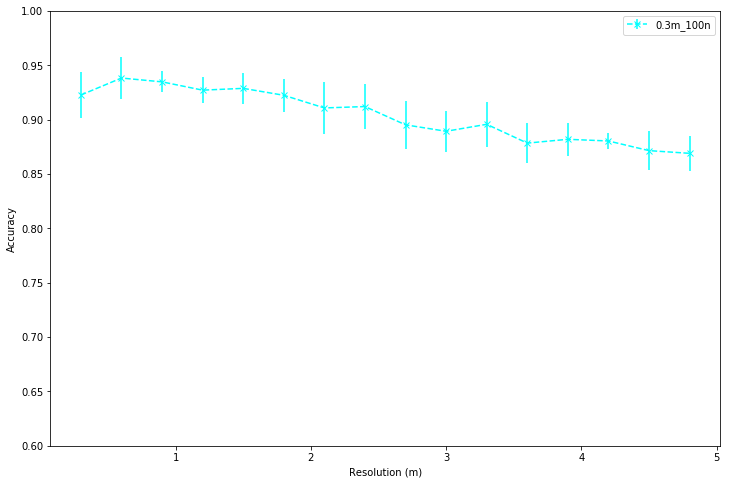

In [12]:
ACC_THRESHOLD = 0.6
RES_NAME = "0.3m_100n"

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

path_results_res = os.path.join(PATH_RESULTS, RES_NAME)
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results.accuracy["mean"], grouped_results.accuracy["std"],
    linestyle='dashed', marker='x', label=RES_NAME, color=CATEGORY_COLOR["all-"+RES_NAME],
)  

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
#ax.grid()
ax.legend()

plt.show()
#fig.savefig(fig_filename_formatter.format("acc_res_03m"), bbox_inches='tight')

### 1m dataset

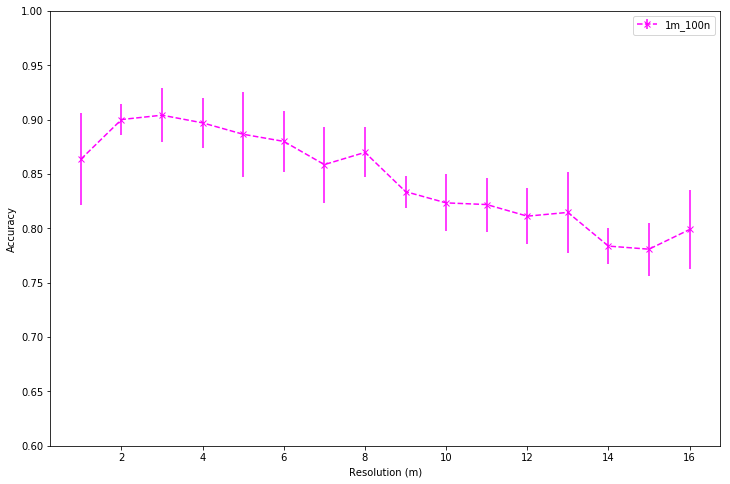

In [13]:
ACC_THRESHOLD = 0.6
RES_NAME = "1m_100n"

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

path_results_res = os.path.join(PATH_RESULTS, RES_NAME)
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results.accuracy["mean"], grouped_results.accuracy["std"],
    linestyle='dashed', marker='x', label=RES_NAME, color=CATEGORY_COLOR["all-"+RES_NAME],
)  

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
#ax.grid()
ax.legend()

plt.show()
#fig.savefig(fig_filename_formatter.format("acc_res_1m"), bbox_inches='tight')

### All datasets

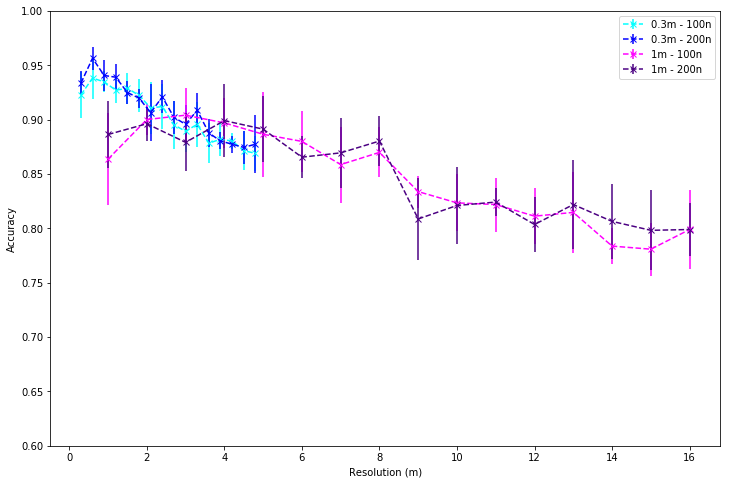

In [14]:
ACC_THRESHOLD = 0.6
RES_NAMES = [
    "0.3m_100n", 
    "0.3m_200n", 
    "1m_100n", 
    "1m_200n",
    #"0.3m",
    #"1m",
    #"0.3-1m",
]

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

for res_name in RES_NAMES:
    path_results_res = os.path.join(PATH_RESULTS, res_name)
    grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
    
    ax.errorbar(
        grouped_results["resolution"], grouped_results.accuracy["mean"], grouped_results.accuracy["std"],
        linestyle='dashed', marker='x', color=CATEGORY_COLOR["all-"+res_name],
        label=res_name.replace("_", " - "),
    )  

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
#ax.grid()
ax.legend()

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_03m_1m"), bbox_inches='tight')

---

## Accuracy by category

### 0.3m dataset

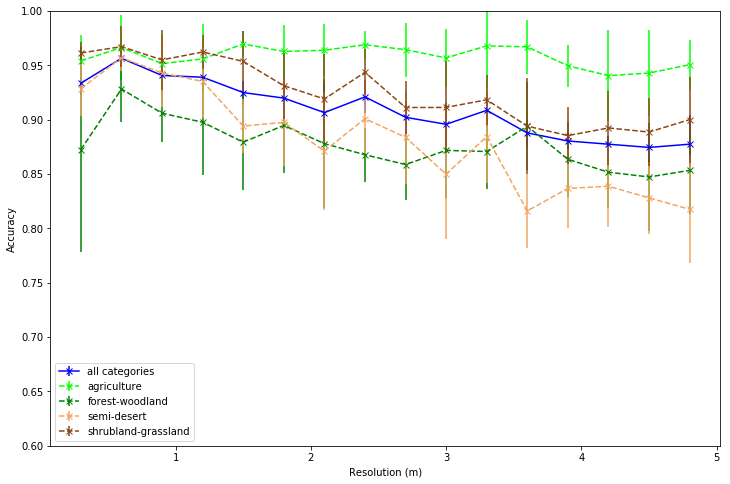

In [15]:
ACC_THRESHOLD = 0.6
RES_NAME = "0.3m_200n"

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

path_results_res = os.path.join(PATH_RESULTS, RES_NAME)
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
    #linestyle='dashed', 
    marker='x', 
    color=CATEGORY_COLOR["all-"+RES_NAME],
    label="all categories"
) 

for cat in CATEGORIES:
    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
#ax.grid()
ax.legend()

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_all_categories_03m"), bbox_inches='tight')

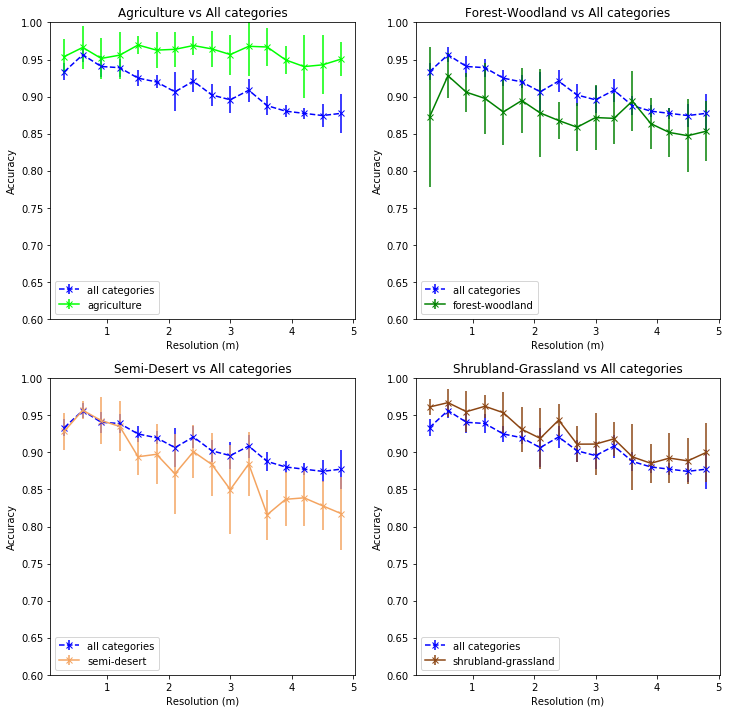

In [16]:
inch_per_plot = 6
fig = plt.figure()
array_width = 2
array_height = math.ceil(len(CATEGORIES)/array_width)
fig.set_size_inches(array_width*inch_per_plot,array_height*inch_per_plot)

for index, cat in enumerate(CATEGORIES):
    ax = fig.add_subplot(array_height,array_width,index+1) 

    ax.errorbar(
        grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR["all-"+RES_NAME],
        label="all categories"
    ) 

    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        #linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

    ax.set(
        xlabel="Resolution (m)",
        ylabel="Accuracy",
        title = cat.title() + " vs All categories",
        ylim=(0.6,1)
    )
    #ax.grid()
    ax.legend(loc='lower left')

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_by_category_03m"), bbox_inches='tight')

### 1m dataset

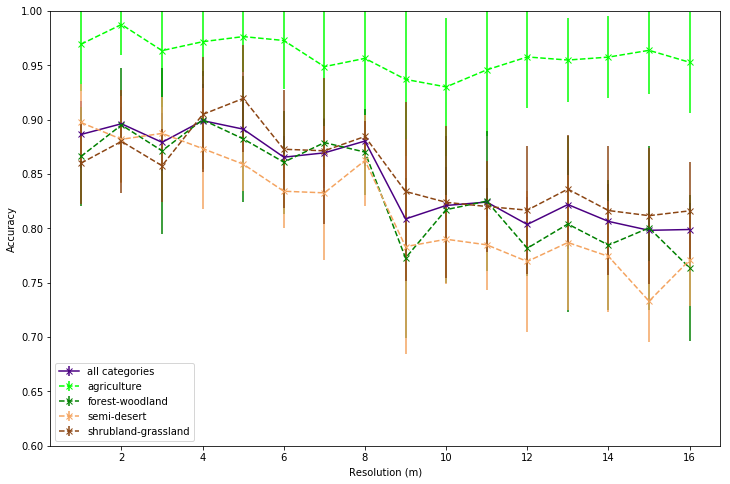

In [17]:
ACC_THRESHOLD = 0.6
RES_NAME = "1m_200n"

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

path_results_res = os.path.join(PATH_RESULTS, RES_NAME)
grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)

ax.errorbar(
    grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
    #linestyle='dashed', 
    marker='x', 
    color=CATEGORY_COLOR["all-"+RES_NAME],
    label="all categories"
) 

for cat in CATEGORIES:
    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
#ax.grid()
ax.legend()

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_all_categories_1m"), bbox_inches='tight')

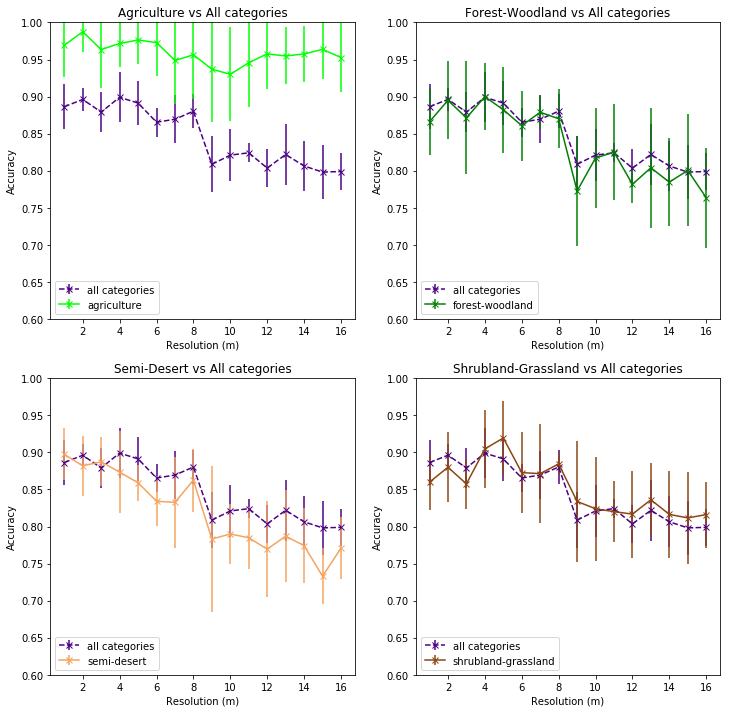

In [18]:
inch_per_plot = 6
fig = plt.figure()
array_width = 2
array_height = math.ceil(len(CATEGORIES)/array_width)
fig.set_size_inches(array_width*inch_per_plot,array_height*inch_per_plot)

for index, cat in enumerate(CATEGORIES):
    ax = fig.add_subplot(array_height,array_width,index+1) 

    ax.errorbar(
        grouped_results["resolution"], grouped_results["accuracy"]["mean"], grouped_results["accuracy"]["std"],
        linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR["all-"+RES_NAME],
        label="all categories"
    ) 

    acc = "accuracy_"+cat
    ax.errorbar(
        grouped_results["resolution"], grouped_results[acc]["mean"], grouped_results[acc]["std"],
        #linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR[cat],
        label=cat
    ) 

    ax.set(
        xlabel="Resolution (m)",
        ylabel="Accuracy",
        title = cat.title() + " vs All categories",
        ylim=(0.6,1)
    )
    #ax.grid()
    ax.legend(loc='lower left')

plt.show()
fig.savefig(fig_filename_formatter.format("acc_res_by_category_1m"), bbox_inches='tight')

### All datasets

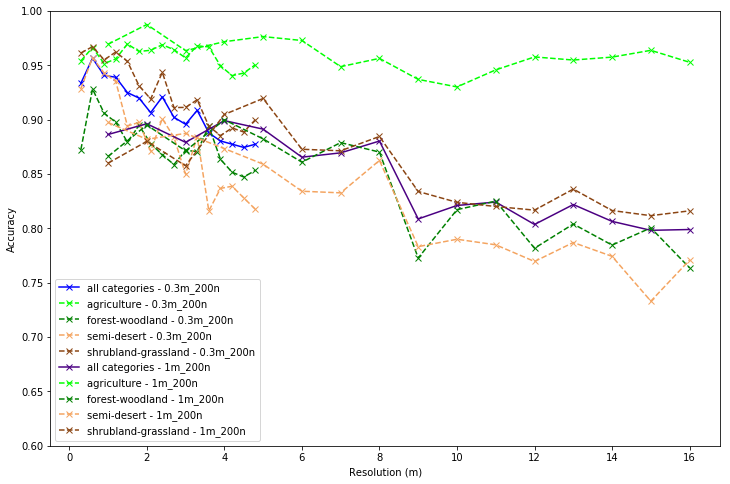

In [19]:
ACC_THRESHOLD = 0.6
RES_NAMES = [
    #"0.3m_100n", 
    "0.3m_200n", 
    #"1m_100n", 
    "1m_200n",
    #"0.3m",
    #"1m",
    #"0.3-1m",
]

fig, ax = plt.subplots()
fig.set_size_inches(12,8)

for res_name in RES_NAMES:
    path_results_res = os.path.join(PATH_RESULTS, res_name)
    grouped_results = load_grouped_results(path_results_res, ACC_THRESHOLD)
    
    ax.errorbar(
        grouped_results["resolution"], grouped_results["accuracy"]["mean"],# grouped_results["accuracy"]["std"],
        #linestyle='dashed', 
        marker='x', 
        color=CATEGORY_COLOR["all-"+res_name],
        label="all categories - " +res_name
    ) 

    for cat in CATEGORIES:
        acc = "accuracy_"+cat
        ax.errorbar(
            grouped_results["resolution"], grouped_results[acc]["mean"],# grouped_results[acc]["std"],
            linestyle='dashed', 
            marker='x', 
            color=CATEGORY_COLOR[cat],
            label=cat + " - " + res_name
        ) 

ax.set(
    xlabel="Resolution (m)",
    ylabel="Accuracy",
    #title = "Classification accuracy vs resolution",
    ylim=(0.6,1)
)
#ax.grid()
ax.legend()

plt.show()

---

In [20]:
stop!!!

SyntaxError: invalid syntax (<ipython-input-20-9a9c723360e0>, line 1)

## Transfer Learning on Aerial Imagery - One resolution accuracy

### 0.3m dataset

In [6]:
# parameters
RESULTS_FOLDER = '0.3m_200n'
DATA_FOLDER = RESULTS_FOLDER.split("_")[0]
base_res = 0.3
base_size = 512
N_RES = 17
sizes = load_res_and_sizes(base_res, base_size, N_RES)
ACC_THRESHOLD = 0.6

Sizes dictionary:
 {0.3: (512, 512), 0.6: (256, 256), 0.9: (171, 171), 1.2: (128, 128), 1.5: (102, 102), 1.8: (85, 85), 2.1: (73, 73), 2.4: (64, 64), 2.7: (57, 57), 3.0: (51, 51), 3.3: (47, 47), 3.6: (43, 43), 3.9: (39, 39), 4.2: (37, 37), 4.5: (34, 34), 4.8: (32, 32)}


In [7]:
# load data
X = np.load(os.path.join(PATH_DATA, DATA_FOLDER, "X_images_res" + str(base_res) + ".npy"))
y = np.load(os.path.join(PATH_DATA, DATA_FOLDER, "y_images_res" + str(base_res) + ".npy"))

# load results
path_results_res = os.path.join(PATH_RESULTS, RESULTS_FOLDER)
df_results = load_results(path_results_res)
df_results = df_results[df_results["accuracy"] > ACC_THRESHOLD]

#### Correctly Classified Images at Base Resolution (0.3m)

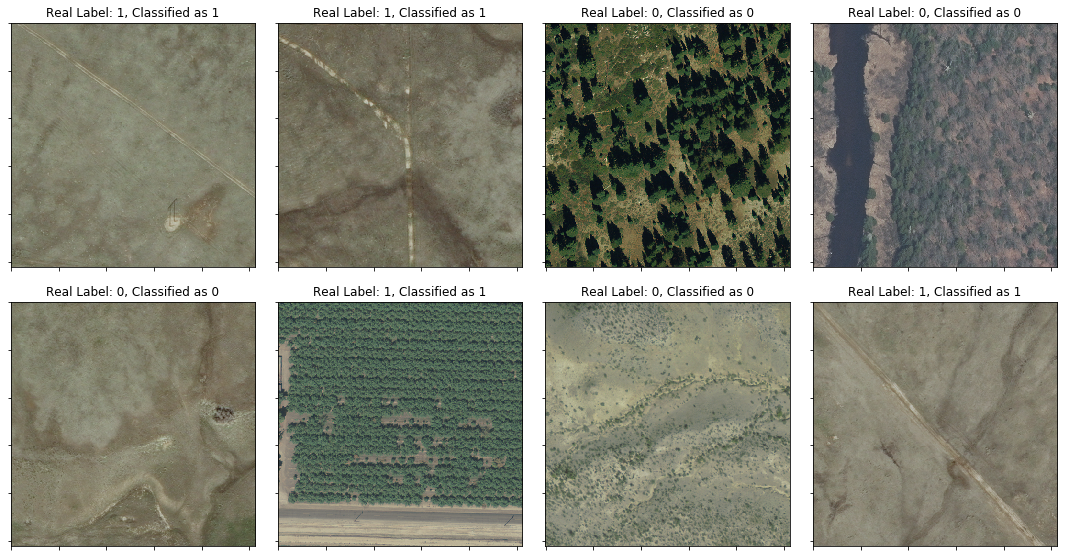

In [22]:
res = base_res
filename = "class_dataset" + str(base_res).replace(".","") + "m_res" + str(res).replace(".","") + "_correct"

X_correct_class, y_real_label, _ = dp.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 8, misclf = False
)
fig = dp.plot_misclf_or_correctclf_images(
    X_correct_class, y_real_label, columns = 4, misclf = False, degrade = sizes[res]
)
fig.savefig(fig_filename_formatter.format(filename), bbox_inches='tight')

#### Wrongly Classified Images at Base Resolution (0.3m)

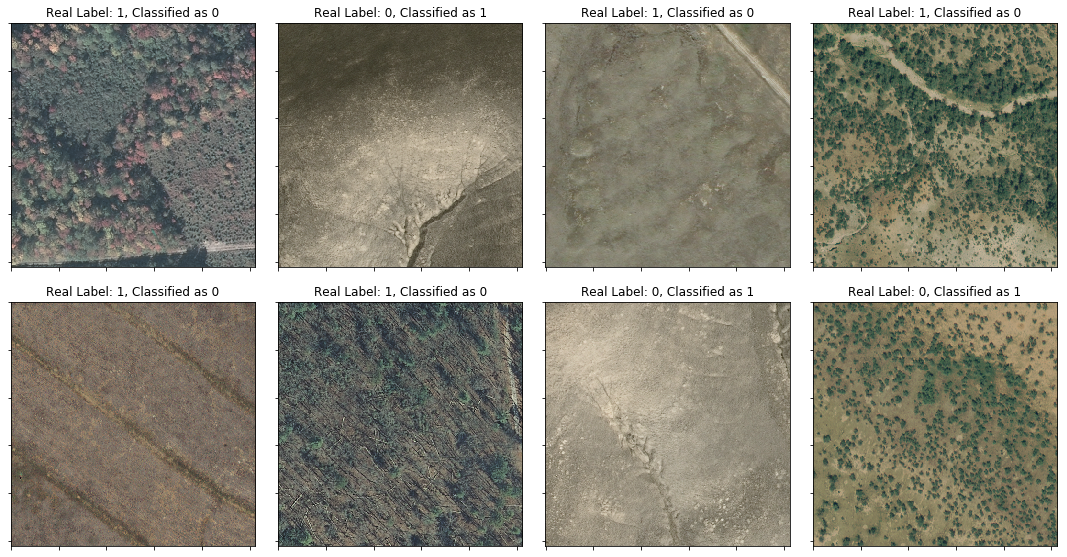

In [24]:
res = base_res
filename = "class_dataset" + str(base_res).replace(".","") + "m_res" + str(res).replace(".","") + "_wrong"

X_wrong_class, y_real_label, _ = dp.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 8, misclf = True
)
fig = dp.plot_misclf_or_correctclf_images(
    X_wrong_class, y_real_label, columns = 4, misclf = True, degrade = sizes[res]
)
fig.savefig(fig_filename_formatter.format(filename), bbox_inches='tight')

#### Correctly Classified Images at Resolution 4.8m

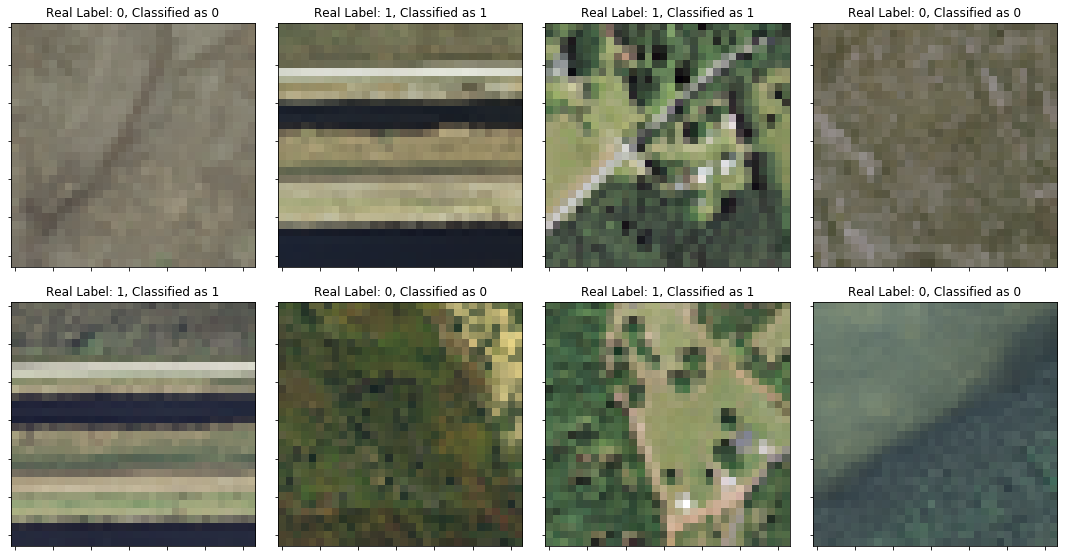

In [25]:
res = 4.8
filename = "class_dataset" + str(base_res).replace(".","") + "m_res" + str(res).replace(".","") + "_correct"

X_correct_class, y_real_label, _ = dp.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 8, misclf = False
)
fig = dp.plot_misclf_or_correctclf_images(
    X_correct_class, y_real_label, columns = 4, misclf = False, degrade = sizes[res]
)
fig.savefig(fig_filename_formatter.format(filename), bbox_inches='tight')

#### Wrongly Classified Images at Resolution 4.8

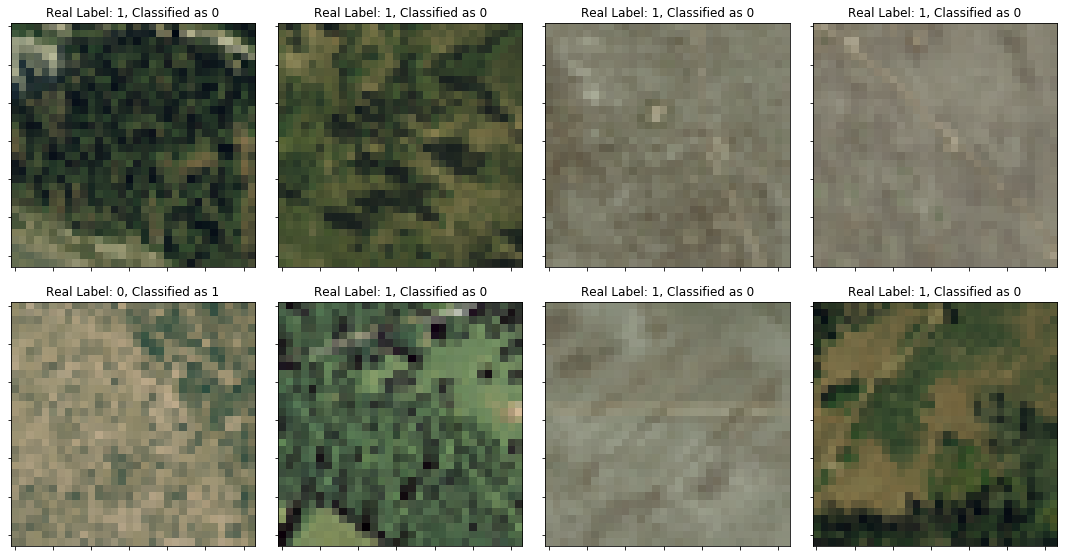

In [26]:
res = 4.8
filename = "class_dataset" + str(base_res).replace(".","") + "m_res" + str(res).replace(".","") + "_wrong"

X_wrong_class, y_real_label, _ = dp.get_misclf_or_correctclf_images(
    X, y, df_results, res = res, n = 8, misclf = True
)
fig = dp.plot_misclf_or_correctclf_images(
    X_wrong_class, y_real_label, columns = 4, misclf = True, degrade = sizes[res]
)
fig.savefig(fig_filename_formatter.format(filename), bbox_inches='tight')

#### Images that were classified correct at 0.3 and wrong at 4.8

In [27]:
def get_misclf_indcs_outersection(X, y, df_results, res1, res2):

    _, _, high_res_indcs = dp.get_misclf_or_correctclf_images(
        X, y, df_results, res =res1, n = None, misclf = True
    )

    _, _, low_res_indcs = dp.get_misclf_or_correctclf_images(
        X, y, df_results, res = res2, n = None, misclf = True
    )
    
    high_minus_low = list(set(high_res_indcs) - set(low_res_indcs))
    low_minus_high = list(set(low_res_indcs) - set(high_res_indcs))
    
    return high_minus_low, low_minus_high

In [31]:
high_res = 0.3
low_res = 4.8
misclf_high, misclf_low = get_misclf_indcs_outersection(X, y, df_results, high_res, low_res)

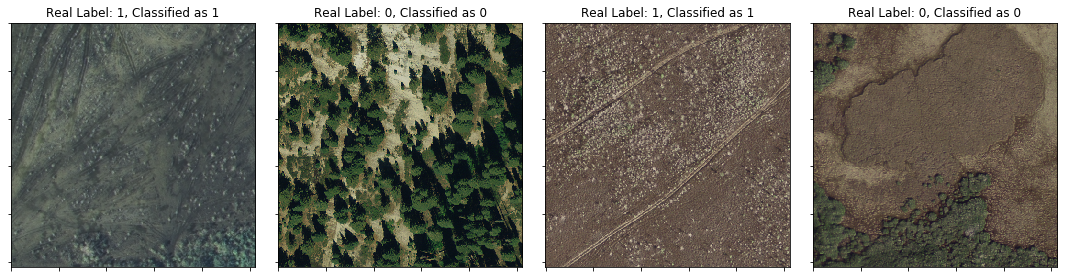

In [35]:
filename = "class_dataset" + str(base_res).replace(".","") + "m_res" + str(high_res).replace(".","") + "_comp_correct"
fig = dp.plot_misclf_or_correctclf_images(
    X[misclf_low], y[misclf_low], n = 4, columns = 4, misclf = False, degrade = sizes[high_res]
)
fig.savefig(fig_filename_formatter.format(filename), bbox_inches='tight')

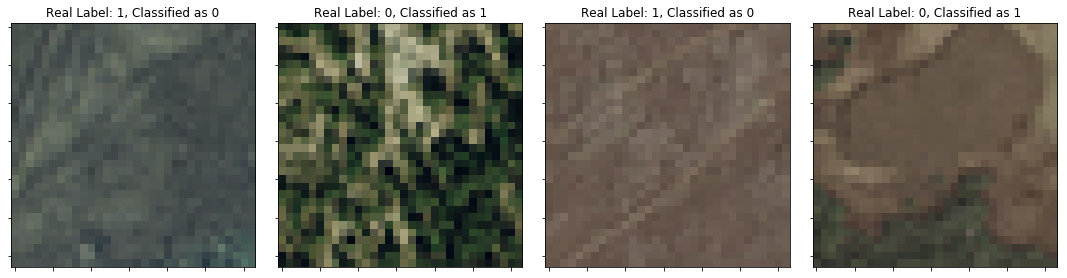

In [36]:
filename = "class_dataset" + str(base_res).replace(".","") + "m_res" + str(low_res).replace(".","") + "_comp_wrong"
fig = dp.plot_misclf_or_correctclf_images(
    X[misclf_low], y[misclf_low], n = 4, columns = 4, misclf = True, degrade = sizes[low_res]
)
fig.savefig(fig_filename_formatter.format(filename), bbox_inches='tight')

#### Classify images of label 1

Load data:

In [36]:
X_l1_base = np.load(os.path.join(PATH_DATA, DATA_FOLDER, "X_l1_images_res" + str(base_res) + ".npy"))
#y_l1_base = np.load(os.path.join(PATH_DATA, DATA_FOLDER, "y_l1_images_res" + str(base_res) + ".npy"), allow_pickle = True)

SAMPLES = 100
X_l1_base = X_l1_base[:SAMPLES]
#y_l1_base = y_l1_base[:SAMPLES]

Load ResNet:

In [38]:
base_model = ResNet50(weights='imagenet', include_top=False)

activation_layers = []
for l in base_model.layers:
    l.trainable = False
    if "activation" in l.name or "relu" in l.name:
        activation_layers.append(l.name)
print(activation_layers)

/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


['activation_148', 'activation_149', 'activation_150', 'activation_151', 'activation_152', 'activation_153', 'activation_154', 'activation_155', 'activation_156', 'activation_157', 'activation_158', 'activation_159', 'activation_160', 'activation_161', 'activation_162', 'activation_163', 'activation_164', 'activation_165', 'activation_166', 'activation_167', 'activation_168', 'activation_169', 'activation_170', 'activation_171', 'activation_172', 'activation_173', 'activation_174', 'activation_175', 'activation_176', 'activation_177', 'activation_178', 'activation_179', 'activation_180', 'activation_181', 'activation_182', 'activation_183', 'activation_184', 'activation_185', 'activation_186', 'activation_187', 'activation_188', 'activation_189', 'activation_190', 'activation_191', 'activation_192', 'activation_193', 'activation_194', 'activation_195', 'activation_196']
__________________________________________________________________________________________________
Layer (type)      

Compute activations from the ResNet

In [39]:
X_l1_act = dl.preprocess_activations(X_l1_base, base_model, activation_name=int(activation_layers[-1].split("_")[-1]))

--- getting activations ---


Load model and predict:

In [79]:
res = 0.3
models_folder = '0.3m_200n'
fold = 3

model_path = os.path.join(PATH_MODELS, models_folder, "model_res" + str(res) + "_fold" + str(fold))
model = dl.load_keras_model(model_path)

y_l1_hats = model.predict_classes(X_l1_act)
y_l1_hats = np.array([y_hat[0] for y_hat in y_l1_hats])

Plot results:

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


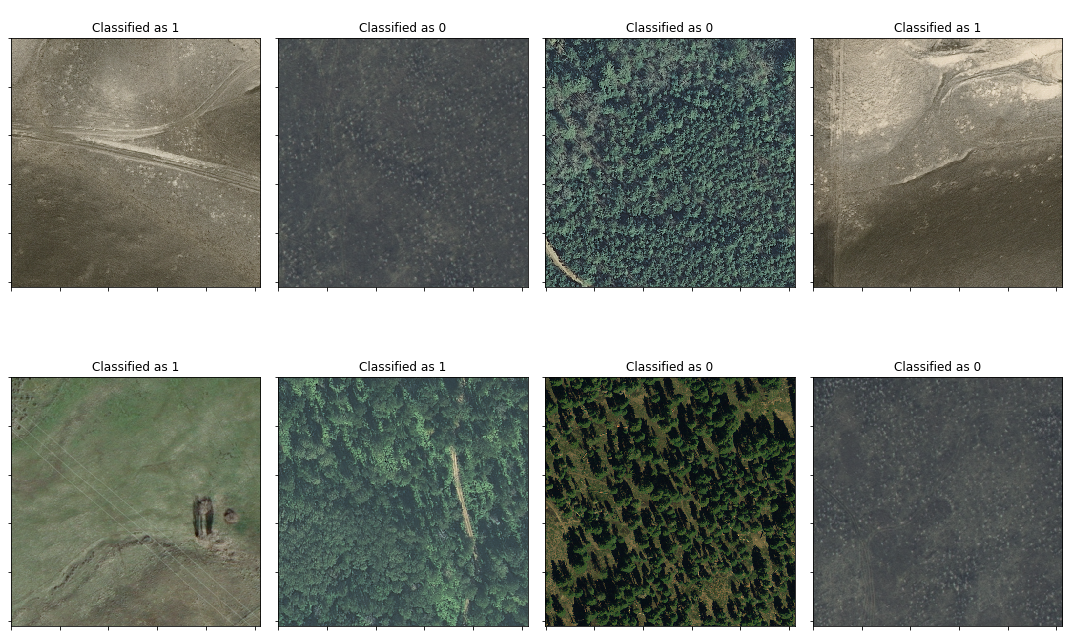

In [89]:
plot_samples = 10
indcs = random.sample(range(len(y_l1_hats)), k=plot_samples)

fig = dp.plot_misclf_or_correctclf_images(
    X_l1_base[indcs], y_l1_hats[indcs], columns = 4, n=plot_samples, show_real_label = False
)

filename = "class_dataset" + str(base_res).replace(".","") + "m_res" + str(res).replace(".","") + "_l1"
fig.savefig(fig_filename_formatter.format(filename), bbox_inches='tight')